In [ ]:
!pip install feature_engine

     |████████████████████████████████| 180 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 43.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import RareLabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb


from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, mean_squared_error, plot_confusion_matrix, recall_score

pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Una vez ya tenemos todos nuestros datoa scrapeados y descargados. Tenemos que unir table y limpiar nuestros datos.
# Comenzamos leyendo los archivos

leagues = pd.read_csv(r'/content/drive/MyDrive/Proyecto Final/data/kaggle/leagues.csv')
players = pd.read_csv(r'/content/drive/MyDrive/Proyecto Final/data/kaggle/players.csv', encoding='latin1')
games = pd.read_csv(r'/content/drive/MyDrive/Proyecto Final/data/kaggle/games.csv')
appearances = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/kaggle/appearances.csv')
shots = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/kaggle/shots.csv')
team = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/kaggle/teams.csv')
team_stats = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/kaggle/teamstats.csv')
df = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/football_statistics_pl.csv')
match_2021 = pd.read_excel('/content/drive/MyDrive/Proyecto Final/data/scrapped/Predicciones.xlsx')

In [ ]:
df.drop(columns=['HT_S', 'AT_S', 'H_power', 'A_power'], axis=1, inplace=True)

In [ ]:
df.head()

,season,date,HT,AT,result,H_points,A_points,HT_L5GW,HT_L5GL,HT_L5GD,AT_L5GW,AT_L5GL,AT_L5GD,HT_G,HT_GC,AT_G,AT_GC,HT_XG,AW_XG,HT_SOT,AT_SOT,HT_PPDA,AT_PPDA,HT_C,AT_C,HT_Y,AT_Y,HT_R,AT_R,ELO_HT,ELO_AT
0,2015,2015-08-08 15:45:00,Manchester United,Tottenham,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.627539,0.674600,0,0,0.0,0.0,0,0,0.0,0.0,0,0,1808.0,1728.0
1,2015,2015-08-08 18:00:00,Bournemouth,Aston Villa,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.876106,0.782253,0,0,0.0,0.0,0,0,0.0,0.0,0,0,1592.0,1576.0
2,2015,2015-08-08 18:00:00,Everton,Watford,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.604226,0.557892,0,0,0.0,0.0,0,0,0.0,0.0,0,0,1704.0,1572.0
3,2015,2015-08-08 18:00:00,Leicester,Sunderland,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.568030,1.459460,0,0,0.0,0.0,0,0,0.0,0.0,0,0,1631.0,1603.0
4,2015,2015-08-08 18:00:00,Norwich,Crystal Palace,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.130760,2.109750,0,0,0.0,0.0,0,0,0.0,0.0,0,0,1613.0,1645.0


# Prediccion de Resultado

Vamos a separar nuestros datos en Train y Test

In [ ]:
x = df.iloc[:, 5:] 
y = df.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Local Outlier Factor

Vamos a tener muchos partidos atipicos. Esto va a afectar a nuestro modelo. Tenemos que detectarlos, para ello vamos a usar el modelo no supervisado de Local Outlier Factor, el cual es capaz de identificar los outliers en nuestros datos. Gracias a esto los podemos detectarlos y eliminarlos de nuestros datos.

Vamos a aplicar el LOF solo para nuestros datos de entrenamientos para que el modelo no se vuelva sensible a los Outliers

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', metric='hamming', contamination=0.01)
pred = lof.fit_predict(X_train)
outlier_index = (pred == -1) # Aqui obtenemos los valores de las filas que son outliers

In [ ]:
X_train[outlier_index]

,H_points,A_points,HT_L5GW,HT_L5GL,HT_L5GD,AT_L5GW,AT_L5GL,AT_L5GD,HT_G,HT_GC,AT_G,AT_GC,HT_XG,AW_XG,HT_SOT,AT_SOT,HT_PPDA,AT_PPDA,HT_C,AT_C,HT_Y,AT_Y,HT_R,AT_R,ELO_HT,ELO_AT
821,16,0,4,0,1,0,5,0,17.0,2.0,0.0,13.0,3.475080,0.244321,34,11,10.681960,16.55972,33,23,7.0,14.0,0,0,1832.048989,1566.104056
1494,88,14,5,0,0,0,5,0,79.0,20.0,20.0,69.0,3.589220,0.162400,27,18,9.370100,13.43210,44,25,6.0,9.0,0,0,1936.988986,1449.526045
1538,0,1,0,1,0,0,0,1,0.0,4.0,0.0,0.0,1.226290,0.947941,7,1,6.452400,6.43480,5,12,4.0,0.0,0,0,1786.649212,1671.423597
14,0,0,0,1,0,0,1,0,0.0,1.0,0.0,1.0,1.706140,2.809560,4,1,8.218800,11.91300,2,3,3.0,2.0,0,0,1716.394105,1683.312774
776,0,3,0,1,0,1,0,0,0.0,1.0,4.0,3.0,0.692644,1.406580,1,10,14.450000,5.44440,7,9,1.0,0.0,0,0,1640.618332,1822.713755
1914,0,0,0,1,0,0,1,0,0.0,1.0,0.0,1.0,2.277080,2.280040,5,5,3.608700,11.33330,3,5,1.0,1.0,0,0,1675.187801,1738.513708
1911,0,0,0,1,0,0,1,0,3.0,4.0,0.0,3.0,1.452540,1.555030,3,2,9.333300,32.69230,0,2,0.0,2.0,0,0,1616.616231,1544.662127
770,1,3,0,0,1,1,0,0,0.0,0.0,4.0,0.0,0.304164,3.410210,0,5,12.882400,9.36000,0,11,1.0,2.0,0,0,1661.015965,1803.985307
783,0,0,0,2,0,0,2,0,0.0,3.0,2.0,7.0,2.761070,0.558484,7,9,21.671050,18.40575,8,3,5.0,3.0,1,1,1585.402121,1651.423743
814,13,0,4,0,1,0,5,0,16.0,2.0,0.0,8.0,5.725430,0.611018,38,15,7.695720,12.05972,41,33,9.0,14.0,2,0,1871.207601,1570.620461


In [ ]:
X_train_clean = X_train.iloc[pred != -1, :]
y_train_clean = y_train[pred != -1]
X_train_clean.shape

(1580, 26)

In [ ]:
# Vamos a estandarizar nuestros datos antes de usar algun modelo

scaler = StandardScaler()
X_train_clean = scaler.fit_transform(X_train_clean)
X_test = scaler.fit_transform(X_test)

## Vamos a ver que modelo se comporta mejor a nuestros datos.

#### Hyperparametros del RandomForest

In [ ]:
# Buscamos los mejores hyper parametros para el Random Forest

cv = KFold(n_splits=5)
param_grid = {'n_estimators': [100, 150, 200, 250, 300], 
              'max_depth': range(2, 9, 1),
              'max_features': ['auto', 'sqrt'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]
              }

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv)
grid.fit(X_train_clean, y_train_clean)

KeyboardInterrupt: ignored

In [ ]:
grid.best_params_

In [ ]:
rf_params = {'bootstrap': True,
             'max_depth': 8,
             'max_features': 'auto',
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 200}
# Pesos
# 1: 0.75
# 2: 1.04
# 0: 1.42
# class_weight={0:1.42, 1:0.75, 2:1.04}

forest = RandomForestClassifier(**rf_params)
# max_depth=6, n_estimators=250, random_state=42

forest.fit(X_train_clean, y_train_clean)
forest.score(X_train_clean, y_train_clean), forest.score(X_test, y_test)

#### Hyperparametros del xGBoost

In [ ]:
cv = KFold(n_splits=5)

param_grid = {
        'min_child_weight': [5, 10, 15],
        'gamma': [1, 1.5, 2, 5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300]
        }

grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid)
grid.fit(X_train_clean, y_train_clean)

In [ ]:
grid.best_params_

In [ ]:
x_params = {'colsample_bytree': 0.8,
 'gamma': 1.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.6}

xgboost = xgb.XGBClassifier(**x_params, random_state=42)

xgboost.fit(X_train_clean, y_train_clean)
xgboost.score(X_train_clean, y_train_clean), xgboost.score(X_test, y_test)

## Recursive Feature Elimination

#### Random Forest

In [ ]:
# Una vez hemos identificado nuestros outliers, vamos a ver que columnas son mas importantes que otras antes de pasarlo
# a nuestro modelo, ya que si usamos todos nuestros datos, podriamos estar metiendo ruido y afectar negativamente al 
# desempeño del mismo

# Con los parametros del GridSearch
rfe = RFECV(estimator=RandomForestClassifier(**rf_params, random_state=42))
rfe.fit(X_train_clean, y_train_clean)

In [ ]:
rfe.ranking_

In [ ]:
x.columns

In [ ]:
# Eliminamos las columnas con poco peso de nuestros datos

X_train_rfe = X_train_clean[:, rfe.support_]
X_test_rfe = X_test[:, rfe.support_]

In [ ]:
forest = RandomForestClassifier(**rf_params, random_state=42)
forest.fit(X_train_rfe, y_train_clean)
forest.score(X_train_rfe, y_train_clean), forest.score(X_test_rfe, y_test)

In [ ]:
# Usando los hyper parametros optimizados y quitando columnas con informacion no relevante obtenemos los mejores Scores. rf_params
# Si usamos los otros parametros obtenemos un score entre entrenamiento y prueba no tan lejano

#### XGBClassifier

In [ ]:
rfe = RFECV(estimator=xgb.XGBClassifier(**x_params, random_state=42))
rfe.fit(X_train_clean, y_train_clean)

In [ ]:
rfe.ranking_

In [ ]:
X_train_rfe = X_train_clean[:, rfe.support_]
X_test_rfe = X_test[:, rfe.support_]

In [ ]:
xgboost = xgb.XGBClassifier(**x_params, random_state=42)

xgboost.fit(X_train_rfe, y_train_clean)
xgboost.score(X_train_rfe, y_train_clean), xgboost.score(X_test_rfe, y_test)

Podemos ver que luego de eliminar las columnas el modelo que se comporta mejor es el de Random Forest. Este modelo es capaz de entender el 61% de nuestros datos de prueba. Esto es mejor que decir que el resultado es aleatorio (33%) o que decir que siempre gana el equipo local (46%).

Hay que entender que predecir los resultados de un partido de futbol es algo complicado y muy dificil. Depende de muchos factores y aun asi siempre suceden cosas que no entran en la logica. No siempre el Chelsea le va a ganar al Watford y asi.


## Prediccion PREMIER LEAGUE 2021-2022 WEEK 1, 2


In [ ]:
match_2021.head(20)

In [ ]:
# Week 1
scaler = StandardScaler()
X_pred = scaler.fit_transform(match_2021.iloc[0:10, 2:])
forest.predict(X_pred)

In [ ]:
# Week 2
scaler = StandardScaler()
X_pred = scaler.fit_transform(match_2021.iloc[10:, 2:])
forest.predict(X_pred)

## Evaluacion del Modelo

Vamos a ver nuestra matriz de confusion y asi obtener los parametros necesarios

In [ ]:
plot_confusion_matrix(forest, X_test_rfe, y_test, display_labels=['Tie', 'Local Win', 'Away Win'])

In [ ]:
# Acurracy
y_pred = forest.predict(X_test_rfe)
accuracy_score(y_test, y_pred)

In [ ]:
# Como tenemos un sistema multiclase, vamos a analizar cada caso por separado
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Precision
precision = np.diag(cm) / np.sum(cm, axis = 0) 
precision

In [ ]:
# Recall / Sencibilidad
recall = np.diag(cm) / np.sum(cm, axis = 1)
recall 

In [ ]:
# F1 Score
f1 = [(2*precision[i]*recall[i])/(recall[i]+precision[i]) for i in [0, 1, 2]]
f1

In [ ]:
# Por ultimo vamos a ver nuestro score del ROC
y_prob = forest.predict_proba(X_test_rfe)
roc_auc_score(y_test, y_prob, multi_class='ovo', average='weighted')

A partir de los parametros podemos concluir que nuestro modelos es capaz de predecir de manera correcta las victorias y las derrotas pero no los empates.

Con los empates tenemos unas metricas muy pobres, dando razon a lo observado en la matriz de confusion. Vemos que el recall es bajo, cercano a 0.1, esto nos dice que no esta clasificando bien los verdaderos positivos. Mientras que el recall para el resto de etiquetas es aceptable.

## Pipeline

Por ultimo, vamos a realizar el pipeline para nuestro modelo final.

El accuracy para el train es: 0.860126582278481
El accuracy para el train es: 0.6096491228070176


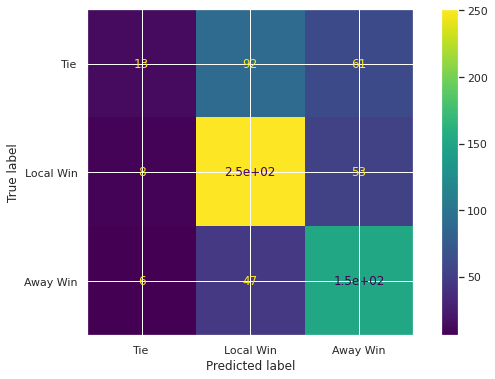

In [ ]:
def pip(x, y, rf_params):

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

  # LOF para detectar outliers. Se los quitamos solo a nuestros datos de entrenamiento
  lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', metric='hamming', contamination=0.01)
  pred = lof.fit_predict(X_train)
  X_train_clean = X_train.iloc[pred != -1, :]
  y_train_clean = y_train[pred != -1]

  # Escalamos nuestros datos
  scaler = StandardScaler()
  X_train_clean = scaler.fit_transform(X_train_clean)
  X_test = scaler.fit_transform(X_test)

  # Buscamos los estimadores mas importantes de nuestra base de datos y los usamos en el modelo
  rfe = RFECV(estimator=RandomForestClassifier(**rf_params, 
                                               random_state=42, 
                                               ))
  rfe.fit(X_train_clean, y_train_clean)
  X_train_rfe = X_train_clean[:, rfe.support_]
  X_test_rfe = X_test[:, rfe.support_]

  # Modelo de Random Forest
  forest = RandomForestClassifier(**rf_params, 
                                  random_state=42, 
                                  )
  forest.fit(X_train_rfe, y_train_clean)


  return forest, forest.score(X_train_rfe, y_train_clean), forest.score(X_test_rfe, y_test), plot_confusion_matrix(forest, X_test_rfe, y_test, display_labels=['Tie', 'Local Win', 'Away Win'])


rf_params = {'bootstrap': True,
             'max_depth': 8,
             'max_features': 'auto',
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 200}

x = df.iloc[:, 5:] 
y = df.iloc[:, 4]

model, accuracy_train, accuracy_test, confusion_matrix = pip(x, y, rf_params)
print(f'El accuracy para el train es: {accuracy_train}')
print(f'El accuracy para el train es: {accuracy_test}')

In [ ]:
match_2021.head(20)

,HT,AT,H_points,A_points,HT_L5GW,HT_L5GL,AT_L5GW,AT_L5GL,HT_G,HT_GC,AT_G,AT_GC,HT_XG,AW_XG,HT_SOT,AT_SOT,HT_PPDA,AT_PPDA,HT_C,AT_C,HT_Y,AT_Y,ELO_HT,ELO_AT
0,Brentford,Arsenal,0,0,0,0,0,0,0,0,0,0,1.3,1.5,0,0,0.00,0.00,0,0,0,0,1668,1863
1,Manchester Utd,Leeds United,0,0,0,0,0,0,0,0,0,0,1.5,0.6,0,0,0.00,0.00,0,0,0,0,1922,1780
2,Leicester City,Wolves,0,0,0,0,0,0,0,0,0,0,0.8,1.1,0,0,0.00,0.00,0,0,0,0,1798,1735
3,Burnley,Brighton,0,0,0,0,0,0,0,0,0,0,1.0,1.3,0,0,0.00,0.00,0,0,0,0,1705,1717
4,Watford,Aston Villa,0,0,0,0,0,0,0,0,0,0,1.2,1.1,0,0,0.00,0.00,0,0,0,0,1670,1743
5,Chelsea,Crystal Palace,0,0,0,0,0,0,0,0,0,0,0.9,0.3,0,0,0.00,0.00,0,0,0,0,1919,1689
6,Everton,Southampton,0,0,0,0,0,0,0,0,0,0,2.4,0.7,0,0,0.00,0.00,0,0,0,0,1767,1697
7,Norwich City,Liverpool,0,0,0,0,0,0,0,0,0,0,1.4,2.0,0,0,0.00,0.00,0,0,0,0,1651,1936
8,Newcastle Utd,West Ham,0,0,0,0,0,0,0,0,0,0,1.4,2.2,0,0,0.00,0.00,0,0,0,0,1721,1807
9,Tottenham,Manchester City,0,0,0,0,0,0,0,0,0,0,1.3,1.9,0,0,0.00,0.00,0,0,0,0,1827,2009


In [ ]:
# Week 1
scaler = StandardScaler()
X_pred = scaler.fit_transform(match_2021.iloc[0:10, 2:])
model.predict(X_pred)

array([1, 1, 2, 2, 1, 1, 1, 2, 2, 2])

In [ ]:
# Week 2
scaler = StandardScaler()
X_pred = scaler.fit_transform(match_2021.iloc[10:, 2:])
model.predict(X_pred)

array([1, 1, 1, 2, 2, 1, 2, 2, 2, 1])

# Prediccion de Goles

### Analisis y Tratamiento de Datos

A partir de los datos que tenemos sobre los tiros al arco, vamos a tratar de predecir cuales van a terminar en gol y cuales no. 

In [ ]:
shots = pd.read_csv('/content/drive/MyDrive/Proyecto Final/data/kaggle/shots.csv')
shots.head()

,gameID,shooterID,assisterID,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY
0,81,554,NaN,27,DirectFreekick,Standard,LeftFoot,BlockedShot,0.104347,0.794,0.421
1,81,555,631.0,27,SetPiece,Pass,RightFoot,BlockedShot,0.064342,0.860,0.627
2,81,554,629.0,35,OpenPlay,Pass,LeftFoot,BlockedShot,0.057157,0.843,0.333
3,81,554,NaN,35,OpenPlay,Tackle,LeftFoot,MissedShots,0.092141,0.848,0.533
4,81,555,654.0,40,OpenPlay,BallRecovery,RightFoot,BlockedShot,0.035742,0.812,0.707


Lo primero que tenemos que hacer es transformar las distancias y calcular los metros que separan al tiro y el centro de la porteria y el angulo del tiro. Posteriormente, se realizara un poco de data engeniering para transformar las etiquetas de situation, las action y shottype a un OneHotEncoding

In [ ]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324543 entries, 0 to 324542
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameID      324543 non-null  int64  
 1   shooterID   324543 non-null  int64  
 2   assisterID  240199 non-null  float64
 3   minute      324543 non-null  int64  
 4   situation   324543 non-null  object 
 5   lastAction  324543 non-null  object 
 6   shotType    324543 non-null  object 
 7   shotResult  324543 non-null  object 
 8   xGoal       324543 non-null  float64
 9   positionX   324543 non-null  float64
 10  positionY   324543 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 27.2+ MB


In [ ]:
shots.isnull().sum()

gameID            0
shooterID         0
assisterID    84344
minute            0
situation         0
lastAction        0
shotType          0
shotResult        0
xGoal             0
positionX         0
positionY         0
dtype: int64

In [ ]:
# Tiramos la columna de Assister ya que no nos sirve. Lo mismo con gameID y shooterID.
# Es importante destacar que no es lo mismo que el tiro lo haga Messi a Vardy, pero para realizar dicha estimacion hacen falta mas datos.
#  'xGoal'
shots.drop(columns=['gameID', 'shooterID', 'assisterID'], inplace=True)
shots.isnull().sum()

minute        0
situation     0
lastAction    0
shotType      0
shotResult    0
xGoal         0
positionX     0
positionY     0
dtype: int64

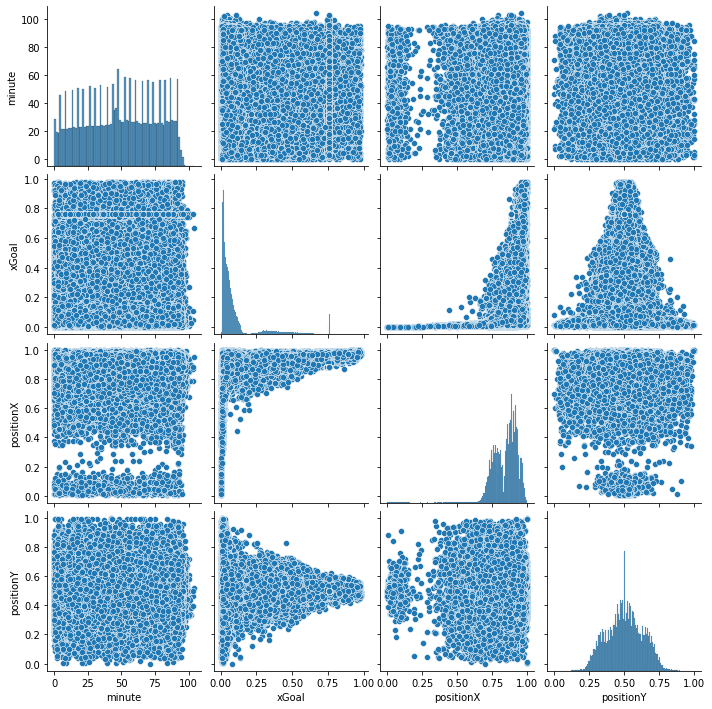

In [ ]:
# Vamos a observar las distribuciones de nuestras variables
sns.pairplot(shots);

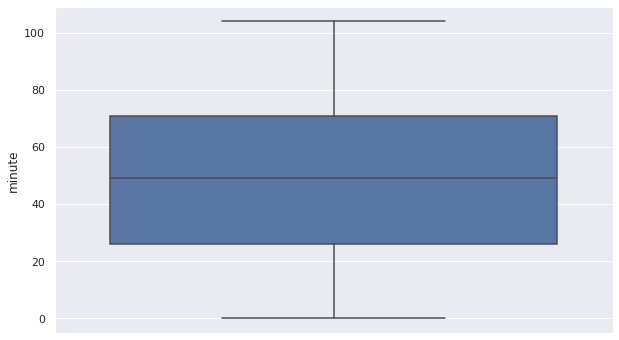

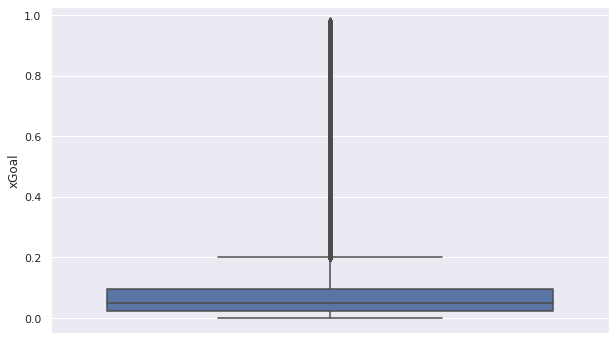

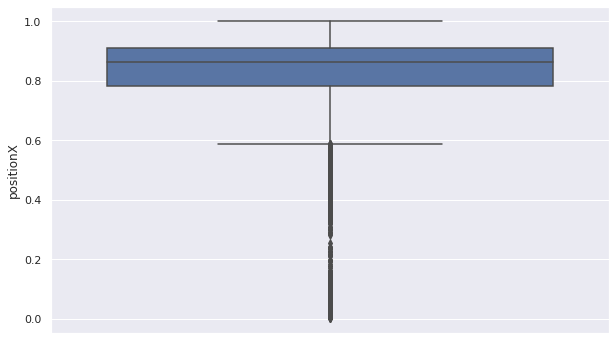

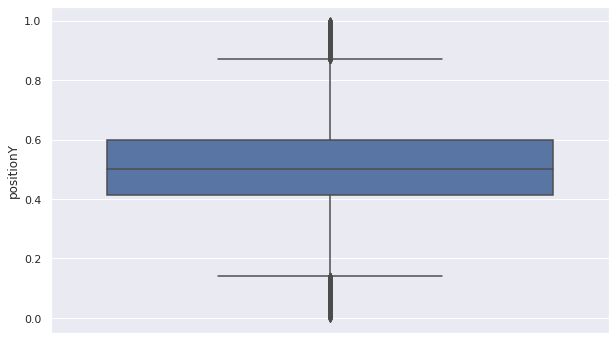

In [ ]:
# Vamos a ver las outliers de nuestras variables.

sns.set(rc={'figure.figsize':(10, 6)})
for col in shots._get_numeric_data().columns:
    sns.boxplot(y=shots[col])
    plt.show()

In [ ]:
# Podemos ver que tanto para la posicion de Y como de X tenemos varios outliers. Esto outliers son naturales, ya que hay ciertas posiciones desde
# donde se intentan tiros para hacer gol. No tiene sentido eliminar estos datos ya que por mas raro sea la posicion del tiro puede o no terminar en
# gol y eso es lo espectacular de este deporte

Vamos a eliminar los autogoles del resultado final. Ya que nos va a introducir ruido en nuestros datos. Ademas lo que queremos predecir es si el tiro realizado termina el gol. Los autogoles son accidentes que suceden en el Futbol.

Representan el 0.3% 

In [ ]:
shots.groupby('shotResult').size() / len(shots) * 100

shotResult
BlockedShot    24.647581
Goal           10.629716
MissedShots    39.125786
OwnGoal         0.312439
SavedShot      23.356227
ShotOnPost      1.928250
dtype: float64

In [ ]:
# Entonces tiramos lo autogoles y cambiamos las etiquetas por 1 y 0 para tener un problema de clasificacion binario
shots = shots.drop(shots[shots['shotResult'] == 'OwnGoal'].index).reset_index(drop=True)

result = []
for i in range(len(shots)):
  if shots.loc[i, 'shotResult'] == 'Goal':
    result.append(1)
  else:
    result.append(0)

In [ ]:
shots['shotResult'] = result

In [ ]:
shots['shotResult'].unique()

array([0, 1])

In [ ]:
shots['situation'].unique()

array(['DirectFreekick', 'SetPiece', 'OpenPlay', 'FromCorner', 'Penalty'],
      dtype=object)

In [ ]:
shots['lastAction'].unique()

array(['Standard', 'Pass', 'Tackle', 'BallRecovery', 'None', 'Cross',
       'Chipped', 'Rebound', 'Aerial', 'Dispossessed', 'Throughball',
       'HeadPass', 'TakeOn', 'LayOff', 'BallTouch', 'Interception',
       'Foul', 'Save', 'BlockedPass', 'End', 'Goal', 'Clearance',
       'CornerAwarded', 'GoodSkill', 'OffsidePass', 'Error',
       'KeeperSweeper', 'Challenge', 'SubstitutionOn', 'Card', 'Start',
       'Punch', 'ShieldBallOpp', 'OffsideProvoked', 'KeeperPickup',
       'FormationChange', 'ChanceMissed', 'Smother', 'SubstitutionOff'],
      dtype=object)

In [ ]:
shots['shotType'].unique()

array(['LeftFoot', 'RightFoot', 'Head', 'OtherBodyPart'], dtype=object)

Vemos que para las columnas de shotType, situation y shootResult no tenemos muchas etiquetas, por lo que podemos dejarlas como estan. Pero para lastAction vamos a tener que tomar solo las categorias mas influyentes y el resto agruparlas. Vamos a ver que porcentaje de etiquetas hay 

In [ ]:
shots.head()

,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY
0,27,DirectFreekick,Standard,LeftFoot,0,0.104347,0.794,0.421
1,27,SetPiece,Pass,RightFoot,0,0.064342,0.860,0.627
2,35,OpenPlay,Pass,LeftFoot,0,0.057157,0.843,0.333
3,35,OpenPlay,Tackle,LeftFoot,0,0.092141,0.848,0.533
4,40,OpenPlay,BallRecovery,RightFoot,0,0.035742,0.812,0.707


In [ ]:
x = shots.drop(columns=['shotResult'])
y = shots.loc[:, 'shotResult']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
multi_col = []
for col in X_train.columns:
  if X_train[col].dtype == 'O':
    if X_train[col].nunique() >= 10:
      multi_col.append(col)
      print(X_train.groupby(col)[col].count() / len(X_train) * 100)
      print('------' * 15)

lastAction
Aerial              7.371837
BallRecovery        2.222811
BallTouch           1.527355
BlockedPass         0.113922
Card                0.021636
Challenge           0.018546
ChanceMissed        0.000442
Chipped             5.211728
Clearance           0.014130
CornerAwarded       0.120104
Cross              14.310946
Dispossessed        0.547534
End                 0.075948
Error               0.002649
FormationChange     0.003974
Foul                0.141299
Goal                0.064468
GoodSkill           0.018987
HeadPass            2.459487
Interception        0.116130
KeeperPickup        0.003091
KeeperSweeper       0.000442
LayOff              0.943613
None               11.308341
OffsidePass         0.028260
OffsideProvoked     0.002208
Pass               35.837859
Punch               0.000442
Rebound             4.276505
Save                0.004857
ShieldBallOpp       0.001766
Smother             0.000442
Standard            5.650638
Start               0.003974
Sub

Vamos a tomar todas las categorias con un porcentaje mayor al 4%. Para ello vemos graficamente cuales son y luego se realiza un Rare Label encoding

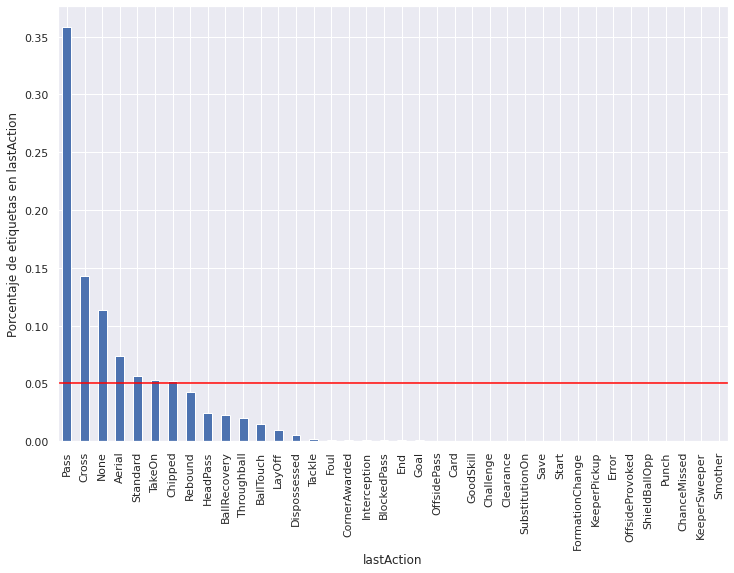

In [ ]:
plt.figure(figsize=(12, 8))
for col in multi_col:
  temp_df = pd.Series(X_train[col].value_counts() / len(X_train))

  fig = temp_df.sort_values(ascending=False).plot.bar()
  fig.set_xlabel(col)

  fig.axhline(y=0.05, color='red')
  fig.set_ylabel(f'Porcentaje de etiquetas en {col}')
  plt.show();

In [ ]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=4, max_n_categories=10, variables='lastAction')
rare_encoder.fit(X_train)
rare_encoder.encoder_dict_

{'lastAction': Index(['Pass', 'Cross', 'None', 'Aerial', 'Standard', 'TakeOn', 'Chipped'], dtype='object')}

In [ ]:
# Trasnformamos nuestros datos.

X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [ ]:
# Vamos a realizar el OHE

X_train = pd.get_dummies(X_train, columns=['shotType', 'situation', 'lastAction'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['shotType', 'situation', 'lastAction'], drop_first=True)

Tenemos que escalar las posiciones X y Y y obtener la distancia al arco y el angulo entre los postes de las arqueria.

In [ ]:
X_train['positionX'] = X_train['positionX'] * 120
X_train['positionY'] = X_train['positionY'] * 90

X_test['positionX'] = X_test['positionX'] * 120
X_test['positionY'] = X_test['positionY'] * 90

In [ ]:
def distance_tp(x1, y1, x2, y2):
  return np.sqrt(((x2-x1)**2)+((y2-y1)**2))

In [ ]:
distances = []
alpha = []
for i in range(len(X_train)):
  distances.append(distance_tp(X_train.iloc[i, 2], X_train.iloc[i, 3], 120, 45))
  distance_post1 = distance_tp(X_train.iloc[i, 2], X_train.iloc[i, 3], 120, 35.84)
  distance_post2 = distance_tp(X_train.iloc[i, 2], X_train.iloc[i, 3], 120, 54.16)
  angle = np.arccos(((18.32**2) - ((distance_post1**2) + (distance_post2**2))) / (-2*distance_post1*distance_post2))
  alpha.append(angle * 180 / np.pi)

In [ ]:
X_train['distance'] = distances
X_train['angle'] = alpha
X_train.drop(columns=['positionX', 'positionY'], inplace=True)

In [ ]:
distances = []
alpha = []
for i in range(len(X_test)):
  distances.append(distance_tp(X_test.iloc[i, 2], X_test.iloc[i, 3], 120, 45))
  distance_post1 = distance_tp(X_test.iloc[i, 2], X_test.iloc[i, 3], 120, 35.84)
  distance_post2 = distance_tp(X_test.iloc[i, 2], X_test.iloc[i, 3], 120, 54.16)
  angle = np.arccos(((18.32**2) - ((distance_post1**2) + (distance_post2**2))) / (-2*distance_post1*distance_post2))
  alpha.append(angle * 180 / np.pi)

In [ ]:
X_test['distance'] = distances
X_test['angle'] = alpha
X_test.drop(columns=['positionX', 'positionY'], inplace=True)

In [ ]:
# Ahora vamos a estandarizar nuestros datos

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modelo

Vamos a ver cuales son los mejores parametros para nuestro modelo de Random Forest.

In [ ]:
cv = KFold(n_splits=5)
param_grid = {'n_estimators': [100, 200, 300], 
              'max_depth': [5, 8, 12]
              }

grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight={0:0.56, 1:4.7}), param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
grid.best_params_

In [ ]:
forest = RandomForestClassifier(n_estimators=200, 
                                max_depth=8,  
                                random_state=42, 
                                class_weight={0:0.56, 1:4.7}
                                )

forest.fit(X_train, y_train)
forest.score(X_train, y_train), forest.score(X_test, y_test) # Scores

(0.8415728352541175, 0.83777908282591)

In [ ]:
# Regresion Logistica

lg = LogisticRegressionCV(random_state=42, class_weight={0:0.56, 1:4.7})
lg.fit(X_train, y_train)
lg.score(X_train, y_train), lg.score(X_test, y_test)

(0.8497549344284011, 0.8500602726176861)

Evaluacion del Modelo

Ya teniendo nuestro modelo, vamos a ver nuestras mediacion para entender como se esta comportando nuestro modelo.

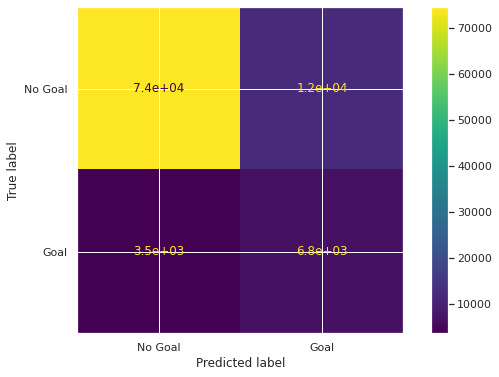

In [ ]:
plot_confusion_matrix(forest, X_test, y_test, display_labels=['No Goal', 'Goal'])

In [ ]:
y_pred = forest.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.83777908282591
Recall: 0.6595806358102232
Precision: 0.35835783284334316
F1: 0.46440112936694217


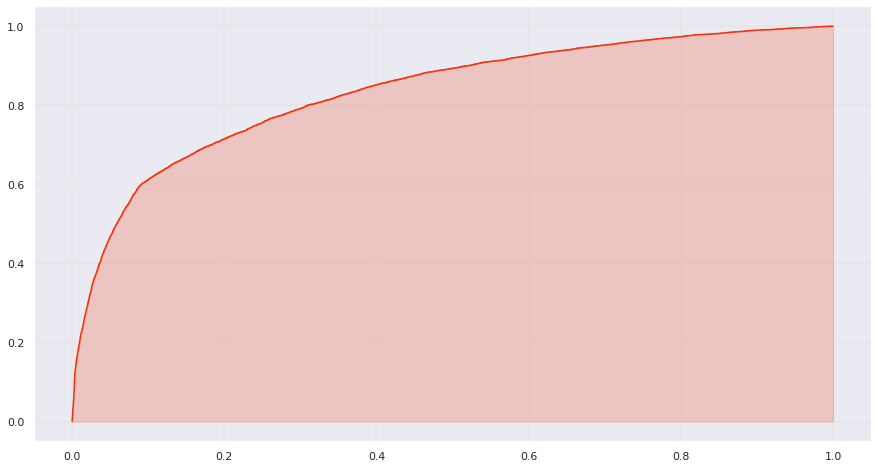

In [ ]:
y_prob = forest.predict_proba(X_test)
fpr, tpr, _  = roc_curve(y_test, y_prob[::, 1])
auc = roc_auc_score(y_test, y_prob[::, 1])

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, c='#F5340B')
plt.grid(color='#E9E6E1', linestyle='-', linewidth=2)
plt.fill_between(fpr, tpr, step="pre", color='#F5340B', alpha=0.2)
plt.savefig(r"roc_auc.png", transparent=True, facecolor='#E9E6E1', edgecolor='#E9E6E1')
plt.show();

In [ ]:
roc_auc_score(y_test, y_prob[::, 1])

0.834043514377852

A partir de las metricas realizadas podemos observar que nuestro modelo es aceptable. En primer lugar, es importante destacar que nuestro datos estan severamente desbalanceados, lo que puede causar que nuestro modelo no sea capaz de predecir la variable con menor numero de datos.

Esto se pudo solventar con una separacion de los datos de goles y no goles de forma simetrica, es decir, tanto los datos de prueba como de entrenamiento tienen los mismo pesos. Dichos pesos se los pasamos al modelo de Random Forest, lo que nos permitio obtener unos buenos resultado.

Entonces debido al desbalance mencionado, nuestro modelo tiene problemas para diferenciar entre goles y tiros fallados, pero a pesar de esto es capaz de distinguir 5300 goles de forma correcta (el total son 10000)

Por otro lado, tenemos una buena metrica del AUC la cual es de 0.801. Esto nos quiere decir que hay un 80% de posibilidades de que nuestro modelo sea capaz de distinguir entre los tiros que terminan en gol y los que no.

In [ ]:
# Hacemos la prediccion de un GOL casi imposible para la presentacion

pre = pd.DataFrame(columns=['minute',	'xGoal',	'shotType_LeftFoot',	'shotType_OtherBodyPart',	'shotType_RightFoot',	
                            'situation_FromCorner',	'situation_OpenPlay',	'situation_Penalty',	'situation_SetPiece',	
                            'lastAction_Chipped',	'lastAction_Cross',	'lastAction_None',	'lastAction_Pass',	'lastAction_Rare',	
                            'lastAction_Standard', 'lastAction_TakeOn',	'distance',	'angle'])
pre.loc[0, :] = [64, 0.012912, 0, 0, 1, 1, 0 ,0, 0, 0, 0, 0, 0, 1, 0, 0, 44.374059, 0.334078]

pre = scaler.fit_transform(pre)
forest.predict(pre)

array([0])

# Algunas graficas para la presentacion

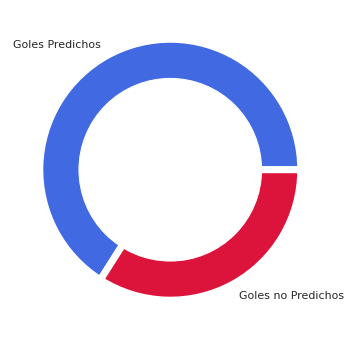

In [ ]:
# Goles predichos correctamente

names = ['Goles Predichos', 'Goles no Predichos']
size = [66, 34]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['royalblue', 'crimson'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig(r"goals.png", transparent=True)
plt.show()

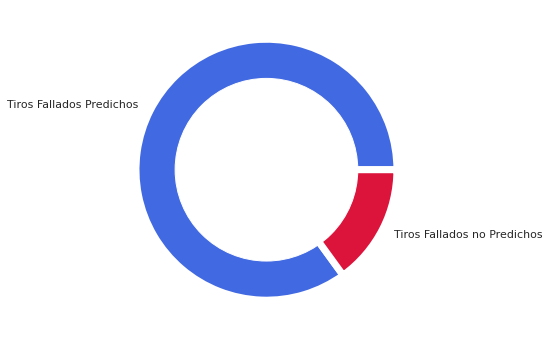

In [ ]:
# Tiros predichos correctamente

names = ['Tiros Fallados Predichos', 'Tiros Fallados no Predichos']
size = [85, 15]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['royalblue', 'crimson'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig(r"no_goals.png", transparent=True)
plt.show()